In [1]:
#IMPORT ALL THE REQUIRED LIBERARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
import torch

In [2]:


# Fix multiprocessing for SDV
os.environ["NUMBA_NUM_THREADS"] = "1"
os.environ["JOBLIB_START_METHOD"] = "spawn"

In [3]:
# Load the dataset
icustays = pd.read_csv('ICUSTAYS.csv.gz')

# Preview the dataset
print(icustays.head())
print(icustays.info())

# Check for missing values
print("Missing values:\n", icustays.isnull().sum())

# Check for duplicates
print("Duplicates:", icustays.duplicated().sum())


   ROW_ID  SUBJECT_ID  HADM_ID  ICUSTAY_ID DBSOURCE FIRST_CAREUNIT  \
0     365         268   110404      280836  carevue           MICU   
1     366         269   106296      206613  carevue           MICU   
2     367         270   188028      220345  carevue            CCU   
3     368         271   173727      249196  carevue           MICU   
4     369         272   164716      210407  carevue            CCU   

  LAST_CAREUNIT  FIRST_WARDID  LAST_WARDID               INTIME  \
0          MICU            52           52  2198-02-14 23:27:38   
1          MICU            52           52  2170-11-05 11:05:29   
2           CCU            57           57  2128-06-24 15:05:20   
3          SICU            52           23  2120-08-07 23:12:42   
4           CCU            57           57  2186-12-25 21:08:04   

               OUTTIME     LOS  
0  2198-02-18 05:26:11  3.2490  
1  2170-11-08 17:46:57  3.2788  
2  2128-06-27 12:32:29  2.8939  
3  2120-08-10 00:39:04  2.0600  
4  2186-12-

In [4]:
# Drop duplicates
icustays.drop_duplicates(inplace=True)

# Drop rows with nulls in critical columns (optional)
icustays_cleaned = icustays.dropna(subset=['INTIME', 'OUTTIME'])

# Convert datetime columns
icustays_cleaned['INTIME'] = pd.to_datetime(icustays_cleaned['INTIME'])
icustays_cleaned['OUTTIME'] = pd.to_datetime(icustays_cleaned['OUTTIME'])

# Encode categorical variables
for col in ['DBSOURCE', 'FIRST_CAREUNIT', 'LAST_CAREUNIT']:
    icustays_cleaned[col] = icustays_cleaned[col].astype('category').cat.codes

# Save cleaned version
icustays_cleaned.to_csv('icustays_cleaned.csv', index=False)


In [18]:
# Load cleaned version
icustays_cleaned = pd.read_csv('icustays_cleaned.csv')

# Generate metadata
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(icustays_cleaned)

# Initialize synthesizer
synthesizer = CTGANSynthesizer(metadata=metadata, epochs=300)
synthesizer.fit(icustays_cleaned)

# Generate synthetic data
synthetic = synthesizer.sample(num_rows=len(icustays_cleaned))
synthetic.to_csv('synthetic_icustays.csv', index=False)


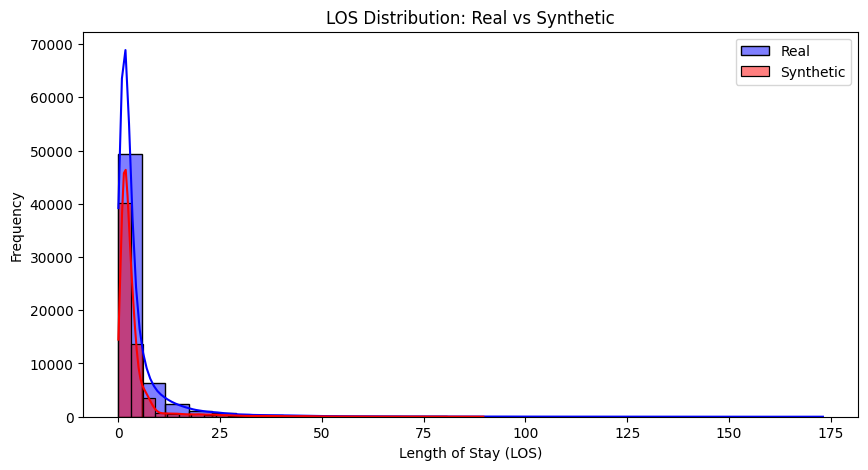

In [19]:
plt.figure(figsize=(10, 5))
sns.histplot(icustays_cleaned['LOS'], label='Real', color='blue', kde=True, bins=30, alpha=0.5)
sns.histplot(synthetic_icustays['LOS'], label='Synthetic', color='red', kde=True, bins=30, alpha=0.5)
plt.title('LOS Distribution: Real vs Synthetic')
plt.xlabel('Length of Stay (LOS)')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

#  Predict HOSPITAL_EXPIRE_FLAG using synthetic vs real
features = ['SUBJECT_ID', 'HADM_ID', 'DBSOURCE', 'LOS']
target = 'FIRST_CAREUNIT'

# Preprocessing (convert categories to codes)
for col in features:
    icustays_cleaned[col] = icustays_cleaned[col].astype('category').cat.codes
    synthetic[col] = synthetic[col].astype('category').cat.codes

# Real data model
X_real = icustays_cleaned[features]
y_real = icustays_cleaned[target]
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_real, y_real, test_size=0.3)

model_real = RandomForestClassifier()
model_real.fit(Xr_train, yr_train)
real_acc = accuracy_score(yr_test, model_real.predict(Xr_test))

# Synthetic data model
X_syn = synthetic[features]
y_syn = synthetic[target]
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X_syn, y_syn, test_size=0.3)

model_syn = RandomForestClassifier()
model_syn.fit(Xs_train, ys_train)
syn_acc = accuracy_score(ys_test, model_syn.predict(Xs_test))

print(f" Model accuracy on real data:     {real_acc:.2f}")
print(f" Model accuracy on synthetic data: {syn_acc:.2f}")



 Model accuracy on real data:     0.37
 Model accuracy on synthetic data: 0.31


In [25]:
from sdv.single_table import TVAESynthesizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Define features and target (from D_CPT structure)
features = ['SUBJECT_ID', 'HADM_ID', 'DBSOURCE', 'LOS']
target_col = 'FIRST_CAREUNIT'

# Create binary classification target
icustays_cleaned['target'] = (icustays_cleaned[target_col] > icustays_cleaned[target_col].median()).astype(int)

# Regenerate metadata (if needed)
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(icustays_cleaned.drop(columns=['target']))

# Fit TVAE (drop target column before fitting)
vae_synthesizer = TVAESynthesizer(metadata=metadata, epochs=30)
vae_synthesizer.fit(icustays_cleaned.drop(columns=['target']))

# Sample synthetic data
synthetic_data_vae = vae_synthesizer.sample(num_rows=1000)

# Add target to synthetic data
synthetic_data_vae['target'] = (synthetic_data_vae[target_col] > icustays_cleaned[target_col].median()).astype(int)

# Encode categorical features
for col in features:
    icustays_cleaned[col] = icustays_cleaned[col].astype('category').cat.codes
    synthetic_data_vae[col] = synthetic_data_vae[col].astype('category').cat.codes

# Train/test split
X_real = icustays_cleaned[features]
y_real = icustays_cleaned['target']
X_vae = synthetic_data_vae[features]
y_vae = synthetic_data_vae['target']

Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_real, y_real, test_size=0.3, random_state=42)
Xv_train, Xv_test, yv_train, yv_test = train_test_split(X_vae, y_vae, test_size=0.3, random_state=42)

# Train models
model_real = RandomForestClassifier(random_state=42)
model_real.fit(Xr_train, yr_train)
real_acc = accuracy_score(yr_test, model_real.predict(Xr_test))

model_vae = RandomForestClassifier(random_state=42)
model_vae.fit(Xv_train, yv_train)
vae_acc = accuracy_score(yv_test, model_vae.predict(Xv_test))

# Results
print(f"Model accuracy on REAL D_CPT data: {real_acc:.2f}")
print(f"Model accuracy on VAE SYNTHETIC D_CPT: {vae_acc:.2f}")


Model accuracy on REAL D_CPT data: 0.67
Model accuracy on VAE SYNTHETIC D_CPT: 0.65


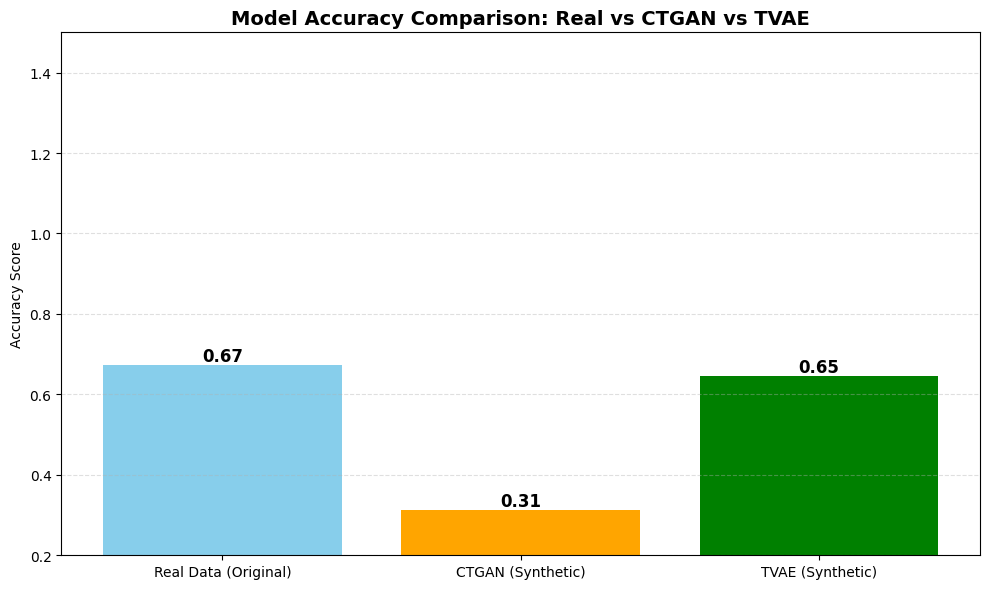

In [26]:
import matplotlib.pyplot as plt

#  accuracy values
# These are from your previous results:
real_acc = real_acc          # Accuracy on real data using real training
vae_acc = vae_acc           # Accuracy on synthetic VAE data
gan_acc = syn_acc           # Accuracy on synthetic GAN (CTGAN) data

# Prepare bar chart data
labels = ['Real Data (Original)', 'CTGAN (Synthetic)', 'TVAE (Synthetic)']
accuracy_scores = [real_acc, gan_acc, vae_acc]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, accuracy_scores, color=['skyblue', 'orange', 'green'])

#  chart elements
plt.title('Model Accuracy Comparison: Real vs CTGAN vs TVAE', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy Score')
plt.ylim(0.2, 1.5)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Annotate bars
for i, acc in enumerate(accuracy_scores):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()